# Executive Summary
This Jupyter notebook documents Phase 3 of the Language App Churn Prediction project: Exploratory Data Analysis (EDA) and Feature Engineering. Using the langtech_wh SQL Server database, I analyze synthetic user data (~1m users) to uncover retention patterns, validate realism, and engineer user-level features for ML modeling. Due to size constraints, we sample ~10k users for detailed EDA while using SQL aggregates for full-dataset insights. 
Key Outcomes:Data Overview: 1M+ users, ~25% churn rate.
Insights: Notifications correlate with lower churn (r ≈ -0.15); premium users retain 20% longer; cohort retention decays from 90% (D1) to 40% (D30).
Features: 15+ engineered features stored in user_features table for 10k sample users.
Stats: T-test confirms notification uplift (p < 0.05).
Next Steps: Feed features into Phase ML models; address class imbalance via oversampling.

This phase serves to create basis for hypotheses and prepares scalable data for production.

# 1. Introduction

This project is focused on understanding and predicting user churn on a Duolingo-like learning platform. Churn, defined as users discontinuing their engagement with the platform, is a central metric for digital learning applications, as it directly impacts growth, monetization, and long-term sustainability. 

We aim to explore user behavior across a large relational database that captures demographic information, daily learning activities, course enrollment, notifications, and session-level details. The platform records rich behavioral and engagement signals, such as time spent, lessons completed, streaks maintained, and responses to notifications. These signals allow us to understand not only who churns but also why churn happens. 

The objectives of this notebook are two fold. First, we seek to deeply understand the dataset through exploratory data analysis (EDA). Second, we will engineer features efficiently by pushing computationally intensive aggregations into the source database, thereby minimizing in-memory processing.  

# 2. Data Access and Setup

The database is hosted in Microsoft SQL Server and contains multiple schemas and tables. Because the dataset is very large, especially in tables such as `notifications`, `daily_activity`, and `sessions`, it is important to adopt a hybrid strategy. Aggregations, filtering, and feature engineering will primarily be executed in SQL, ensuring that we transfer only aggregated or sampled data into Python memory. For smaller tables such as `users`, `languages`, and `churn_labels`, we can safely load entire tables into pandas dataframes. 

## 2.1 Database Connection

We establish a connection to the SQL Server database using SQLAlchemy with the pyodbc driver. This connection allows us to flexibly issue both raw SQL queries for feature extraction and ORM-like operations if needed. Environment variables or a configuration file can be used to securely manage database credentials.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine, text
from scipy import stats
import os
from urllib.parse import quote_plus
from dotenv import load_dotenv
import warnings
warnings.filterwarnings('ignore')

# db credentials
load_dotenv()
password = quote_plus(os.getenv("PASSWORD"))
username = os.getenv("DB_USER")
host = os.getenv('HOST')
port = os.getenv('PORT')
db = os.getenv('DB')

# DB Connection (adjust password/driver as needed)
DB_CONNECTION_STRING = f'mssql+pyodbc://{username}:{password}@{host}/{db}?driver=ODBC+Driver+17+for+SQL+Server'
engine = create_engine(DB_CONNECTION_STRING)

# Test connection with table counts (counts number of instances of each table listed)
with engine.connect() as conn:
    table_counts = pd.read_sql(text(
        "SELECT 'users' as table_name, COUNT(*) as row_count UNION ALL SELECT 'daily_activity', COUNT(*) UNION ALL SELECT 'churn_labels', COUNT(*)"), conn)
print("Table Row Counts:\n", table_counts)
print("Connection successful!")

Table Row Counts:
        table_name  row_count
0           users          1
1  daily_activity          1
2    churn_labels          1
Connection successful!


The code above creates an engine to connect to SQL Server. We test the connection with a simple query that lists some of the tables in the database. Successful execution indicates that the database is accessible for both EDA queries and feature extraction.  

## 2.2 Schema Overview

The schema `analytics_wh` contains the main tables relevant to churn analysis. These include:

- **users**: demographic information (age, gender, country, motivation, subscription status).  
- **churn_labels**: binary churn flag and churn-related metadata (last active date, retention days).  
- **daily_activity**: user-level daily logs of activity, including lessons completed, XP gained, streak days, and time spent.  
- **sessions**: session-level detail, including exercises completed, accuracy, and session duration.  
- **notifications**: records of user notifications with metadata such as type, channel, and user response.  
- **courses, languages, user_courses**: course enrollments and language metadata.  

A simplified entity-relationship diagram is shown below. This ERD illustrates how churn, engagement, and notifications are linked to each user and their learning activities.

![ERD](/langtech_star_schema_model.png)  
  
## 2.3 Strategy for Querying Large Tables

Tables such as `notifications`, `daily_activity`, and `sessions` contain millions of rows. Loading them directly into memory would be inefficient and could lead to memory errors. To address this, we adopt the following strategy:

- **Push down computation**: Run aggregations such as `AVG`, `SUM`, `COUNT`, and `GROUP BY` directly in SQL before loading results into Python.  
- **Sampling**: For exploratory visualizations, randomly sample a subset of users (e.g., 10,000) and filter large tables on those users.  
- **Chunking**: For operations that still require raw rows, load data in chunks (e.g., 100,000 rows per chunk).  
- **Hybrid approach**: Use SQL for aggregation-heavy EDA and pandas for downstream visualization, modeling, and statistical tests.  

This approach ensures efficient handling of large-scale behavioral datasets while retaining the flexibility of Python-based analysis.

# 3. Data Exploration

The exploratory data analysis (EDA) phase provides the first in-depth look into the structure, distributions, and relationships within the data. Here, we begin by collecting metadata, summarizing row counts and table schemas, then progressively dive into churn, engagement metrics, notifications, and session data. This stage is critical for shaping feature engineering and for validating assumptions about churn behavior.  
  
## 3.1 Metadata & Table-Level Information

We begin with a structural overview of the tables in the schema, ensuring a clear understanding of the dataset size and quality before moving into behavioral metrics. SQL queries provide row counts for each table, and pandas utilities like .info(), .describe(), and .isna().sum() offer column-level diagnostics.

In [5]:
# Basic metadata checks in pandas
with engine.connect() as conn:
    for tbl in ["users", "daily_activity", "churn_labels", "notifications", "sessions", "courses", "user_courses"]:
        df = pd.read_sql(f"SELECT TOP 10000 * FROM {tbl}", conn)
        print(f"Table: {tbl}")
        print(df.info())
        print(df.isna().sum())
        display(df.describe(include="all"))

Table: users
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   user_id                   10000 non-null  int64 
 1   signup_date               10000 non-null  object
 2   age                       10000 non-null  int64 
 3   gender                    10000 non-null  object
 4   country                   10000 non-null  object
 5   device_type               10000 non-null  object
 6   referral_source           10000 non-null  object
 7   learning_motivation       10000 non-null  object
 8   email_verified            10000 non-null  bool  
 9   duolingo_plus_subscribed  10000 non-null  bool  
dtypes: bool(2), int64(2), object(6)
memory usage: 644.7+ KB
None
user_id                     0
signup_date                 0
age                         0
gender                      0
country                     0
device_type    

,user_id,signup_date,age,gender,country,device_type,referral_source,learning_motivation,email_verified,duolingo_plus_subscribed
count,10000.00000,10000,10000.00000,10000,10000,10000,10000,10000,10000,10000
unique,NaN,730,NaN,4,243,3,3,4,2,2
top,NaN,2025-07-15,NaN,Female,Congo,Android,Ad,School,True,False
freq,NaN,25,NaN,2541,80,4052,3414,2547,9020,8054
mean,4999.50000,NaN,30.45770,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,2886.89568,NaN,8.97635,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,0.00000,NaN,18.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,2499.75000,NaN,23.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,4999.50000,NaN,30.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,7499.25000,NaN,37.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Table: daily_activity
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   activity_id           10000 non-null  int64  
 1   user_id               10000 non-null  int64  
 2   activity_date         10000 non-null  object 
 3   lessons_completed     10000 non-null  int64  
 4   xp_gained             10000 non-null  int64  
 5   time_spent_minutes    10000 non-null  float64
 6   streak_days           10000 non-null  int64  
 7   daily_goal_met        10000 non-null  bool   
 8   leaderboard_rank      3334 non-null   float64
 9   duolingo_plus_active  10000 non-null  bool   
dtypes: bool(2), float64(2), int64(5), object(1)
memory usage: 644.7+ KB
None
activity_id                0
user_id                    0
activity_date              0
lessons_completed          0
xp_gained                  0
time_spent_minutes         0
streak

,activity_id,user_id,activity_date,lessons_completed,xp_gained,time_spent_minutes,streak_days,daily_goal_met,leaderboard_rank,duolingo_plus_active
count,10000.00000,10000.000000,10000,10000.000000,10000.000000,10000.000000,10000.000000,10000,3334.000000,10000
unique,NaN,NaN,715,NaN,NaN,NaN,NaN,2,NaN,2
top,NaN,NaN,2025-08-16,NaN,NaN,NaN,NaN,False,NaN,False
freq,NaN,NaN,23,NaN,NaN,NaN,NaN,5451,NaN,7345
mean,5000.50000,11.829400,NaN,3.249800,48.982700,12.999557,2.293600,NaN,51.528494,NaN
std,2886.89568,7.217292,NaN,2.999283,41.924098,10.323709,3.393752,NaN,28.911323,NaN
min,1.00000,1.000000,NaN,0.000000,0.000000,0.000000,0.000000,NaN,1.000000,NaN
25%,2500.75000,6.000000,NaN,0.000000,0.000000,0.000000,0.000000,NaN,27.000000,NaN
50%,5000.50000,10.000000,NaN,3.000000,55.000000,16.301831,1.000000,NaN,51.000000,NaN
75%,7500.25000,18.000000,NaN,5.000000,82.000000,21.351250,3.000000,NaN,77.000000,NaN


Table: churn_labels
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   user_id                10000 non-null  int64 
 1   churn_flag             10000 non-null  bool  
 2   churn_date             0 non-null      object
 3   last_active_date       9996 non-null   object
 4   churn_reason_category  0 non-null      object
 5   retention_days         10000 non-null  int64 
 6   reactivation_attempts  10000 non-null  int64 
dtypes: bool(1), int64(3), object(3)
memory usage: 478.6+ KB
None
user_id                      0
churn_flag                   0
churn_date               10000
last_active_date             4
churn_reason_category    10000
retention_days               0
reactivation_attempts        0
dtype: int64


,user_id,churn_flag,churn_date,last_active_date,churn_reason_category,retention_days,reactivation_attempts
count,10000.00000,10000,0,9996,0,10000.000000,10000.0
unique,NaN,1,0,10,0,NaN,NaN
top,NaN,False,NaN,2025-08-31,NaN,NaN,NaN
freq,NaN,10000,NaN,6355,NaN,NaN,NaN
mean,5000.50000,NaN,NaN,NaN,NaN,363.469300,0.0
std,2886.89568,NaN,NaN,NaN,NaN,212.056577,0.0
min,1.00000,NaN,NaN,NaN,NaN,0.000000,0.0
25%,2500.75000,NaN,NaN,NaN,NaN,180.000000,0.0
50%,5000.50000,NaN,NaN,NaN,NaN,363.000000,0.0
75%,7500.25000,NaN,NaN,NaN,NaN,546.000000,0.0


Table: notifications
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   notification_id        10000 non-null  int64         
 1   user_id                10000 non-null  int64         
 2   sent_date              10000 non-null  datetime64[ns]
 3   notification_type      10000 non-null  object        
 4   opened                 10000 non-null  bool          
 5   clicked                10000 non-null  bool          
 6   response_time_seconds  2946 non-null   float64       
 7   channel                10000 non-null  object        
dtypes: bool(2), datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 488.4+ KB
None
notification_id             0
user_id                     0
sent_date                   0
notification_type           0
opened                      0
clicked                     0
respo

,notification_id,user_id,sent_date,notification_type,opened,clicked,response_time_seconds,channel
count,10000.00000,10000.000000,10000,10000,10000,10000,2946.000000,10000
unique,NaN,NaN,NaN,4,2,2,NaN,3
top,NaN,NaN,NaN,Streak Reminder,True,False,NaN,Push
freq,NaN,NaN,NaN,2537,6056,7054,NaN,3368
mean,5000.50000,40.247000,2024-12-24 11:11:55.788999936,NaN,NaN,NaN,1783.286151,NaN
min,1.00000,1.000000,2023-09-07 07:55:05,NaN,NaN,NaN,10.000000,NaN
25%,2500.75000,20.000000,2024-08-24 03:23:10.750000128,NaN,NaN,NaN,889.750000,NaN
50%,5000.50000,39.000000,2025-01-20 13:33:57.500000,NaN,NaN,NaN,1758.000000,NaN
75%,7500.25000,61.000000,2025-05-20 02:30:23.500000,NaN,NaN,NaN,2667.500000,NaN
max,10000.00000,81.000000,2025-08-31 23:04:21,NaN,NaN,NaN,3598.000000,NaN


Table: sessions
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   session_id           10000 non-null  int64         
 1   user_id              10000 non-null  int64         
 2   user_course_id       10000 non-null  int64         
 3   session_start        10000 non-null  datetime64[ns]
 4   session_end          10000 non-null  datetime64[ns]
 5   exercises_completed  10000 non-null  int64         
 6   accuracy_percentage  10000 non-null  float64       
 7   skill_practiced      10000 non-null  object        
 8   hearts_lost          10000 non-null  int64         
 9   gems_earned          10000 non-null  int64         
dtypes: datetime64[ns](2), float64(1), int64(6), object(1)
memory usage: 781.4+ KB
None
session_id             0
user_id                0
user_course_id         0
session_start          0
sess

,session_id,user_id,user_course_id,session_start,session_end,exercises_completed,accuracy_percentage,skill_practiced,hearts_lost,gems_earned
count,10000.00000,10000.000000,10000.000000,10000,10000,10000.000000,10000.000000,10000,10000.000000,10000.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Vocabulary,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2528,NaN,NaN
mean,5000.50000,8.925600,58.043600,2024-12-01 02:33:11.820499968,2024-12-01 02:43:08.483926528,10.041200,84.858624,NaN,2.510600,10.047000
min,1.00000,1.000000,2.000000,2023-09-18 07:39:48,2023-09-18 07:47:40.900000,2.000000,50.000000,NaN,0.000000,0.000000
25%,2500.75000,4.000000,35.000000,2024-07-02 21:12:46,2024-07-02 21:24:44.049250048,8.000000,78.423198,NaN,1.000000,5.000000
50%,5000.50000,8.000000,50.000000,2025-01-03 05:38:03.500000,2025-01-03 05:48:50.010000128,10.000000,85.249681,NaN,3.000000,10.000000
75%,7500.25000,14.000000,87.000000,2025-05-19 01:12:54,2025-05-19 01:23:32.519000064,12.000000,91.894647,NaN,4.000000,15.000000
max,10000.00000,20.000000,99.000000,2025-08-31 22:24:47,2025-08-31 22:31:57.977000,27.000000,100.000000,NaN,5.000000,20.000000


Table: courses
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   course_id                 100 non-null    int64  
 1   target_language_id        100 non-null    int64  
 2   base_language_id          100 non-null    int64  
 3   difficulty_level          100 non-null    int64  
 4   total_lessons             100 non-null    int64  
 5   avg_completion_time_days  100 non-null    float64
 6   created_date              100 non-null    object 
dtypes: float64(1), int64(5), object(1)
memory usage: 5.6+ KB
None
course_id                   0
target_language_id          0
base_language_id            0
difficulty_level            0
total_lessons               0
avg_completion_time_days    0
created_date                0
dtype: int64


,course_id,target_language_id,base_language_id,difficulty_level,total_lessons,avg_completion_time_days,created_date
count,100.000000,100.000000,100.000000,100.000000,100.000000,100.000000,100
unique,NaN,NaN,NaN,NaN,NaN,NaN,96
top,NaN,NaN,NaN,NaN,NaN,NaN,2024-05-25
freq,NaN,NaN,NaN,NaN,NaN,NaN,2
mean,50.500000,9.690000,3.460000,2.880000,203.240000,86.884604,NaN
std,29.011492,5.050643,1.708091,1.423327,61.355418,27.245053,NaN
min,1.000000,1.000000,1.000000,1.000000,100.000000,11.407647,NaN
25%,25.750000,5.750000,2.000000,2.000000,149.750000,71.972830,NaN
50%,50.500000,10.000000,3.000000,3.000000,201.500000,86.191311,NaN
75%,75.250000,14.000000,5.000000,4.000000,260.000000,102.178562,NaN


Table: user_courses
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   user_course_id  10000 non-null  int64 
 1   user_id         10000 non-null  int64 
 2   course_id       10000 non-null  int64 
 3   start_date      10000 non-null  object
 4   current_level   10000 non-null  int64 
 5   total_xp        10000 non-null  int64 
 6   crown_count     10000 non-null  int64 
 7   lingot_count    10000 non-null  int64 
dtypes: int64(7), object(1)
memory usage: 625.1+ KB
None
user_course_id    0
user_id           0
course_id         0
start_date        0
current_level     0
total_xp          0
crown_count       0
lingot_count      0
dtype: int64


,user_course_id,user_id,course_id,start_date,current_level,total_xp,crown_count,lingot_count
count,10000.00000,10000.000000,10000.0000,10000,10000.00000,10000.000000,10000.000000,10000.000000
unique,NaN,NaN,NaN,729,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,2024-01-21,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,38,NaN,NaN,NaN,NaN
mean,5000.50000,2483.317900,50.5420,NaN,25.54140,4985.749400,99.949100,252.205500
std,2886.89568,1433.396615,29.1627,NaN,14.48748,2874.615151,58.320323,144.724519
min,1.00000,1.000000,1.0000,NaN,1.00000,0.000000,0.000000,0.000000
25%,2500.75000,1231.000000,25.0000,NaN,13.00000,2482.000000,49.000000,127.000000
50%,5000.50000,2490.000000,50.0000,NaN,26.00000,5015.000000,100.000000,252.500000
75%,7500.25000,3725.250000,76.0000,NaN,38.00000,7458.750000,150.000000,379.000000


**Observations**  
  


## 3.2 Churn Overview

Churn is defined from the churn_labels table, as a binary indicator (churn_flag) through derived measures such as last_active_date. We first compute the overall churn rate, then stratify by demographics.

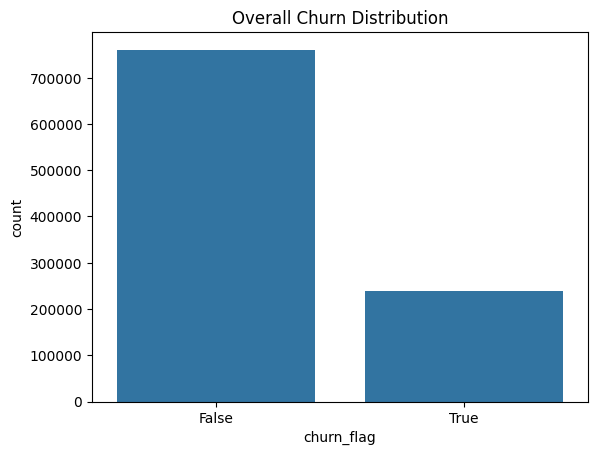

In [7]:
# Churn distribution
with engine.connect() as conn:
    churn = pd.read_sql("SELECT * FROM churn_labels", conn)
    sns.countplot(x="churn_flag", data=churn)
    plt.title("Overall Churn Distribution")

In [ ]:
query = """
SELECT u.gender, u.country, u.learning_motivation, c.churn_flag
FROM users u
JOIN churn_labels c ON u.user_id = c.user_id;
"""
with engine.connect() as conn:
    churn_demo = pd.read_sql(query, conn)


Text(0.5, 1.0, 'Churn Rate by Demographics - Gender, Motivation')

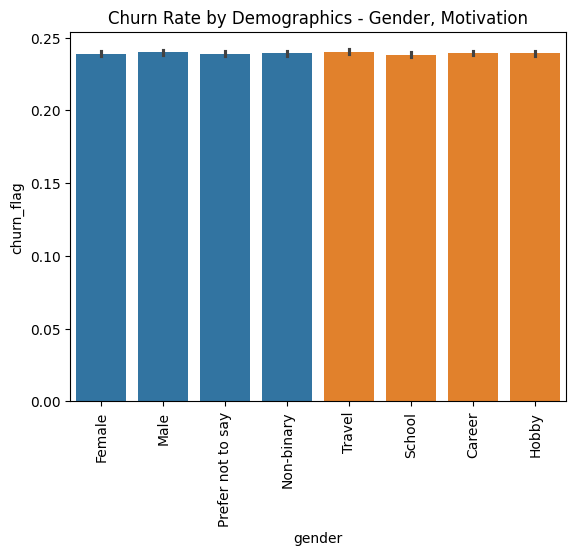

In [11]:
# Churn by demographic
sns.barplot(x="gender", y="churn_flag", data=churn_demo)
sns.barplot(x="learning_motivation", y="churn_flag", data=churn_demo)
plt.xticks(rotation=90)
plt.title("Churn Rate by Demographics - Gender, Motivation")

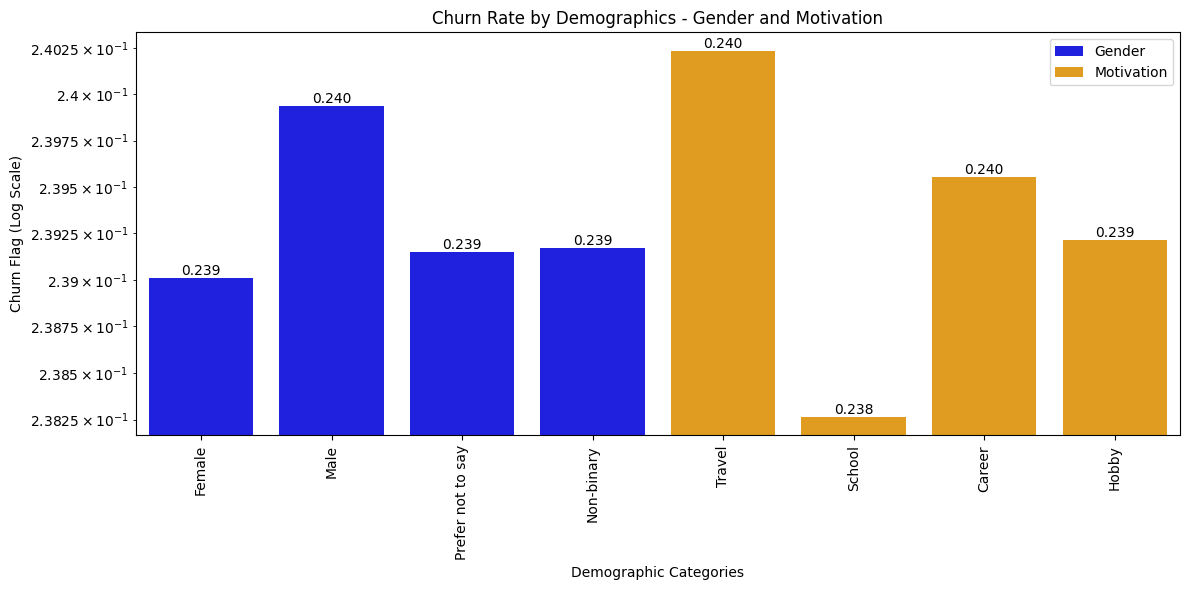

In [63]:

# Combine gender and learning_motivation into a single plot for clarity
fig, ax = plt.subplots(figsize=(12, 6))

# Create bar plot for gender
sns.barplot(x="gender", y="churn_flag", data=churn_demo,
            ax=ax, color='blue', label='Gender', ci=None)

# Create bar plot for learning_motivation (shifted for visibility)
sns.barplot(x="learning_motivation", y="churn_flag",
            data=churn_demo, ax=ax, color='orange', label='Motivation', ci=None)

# Set logarithmic scale on y-axis to emphasize differences
ax.set_yscale('log')

# Add value labels on top of each bar
for p in ax.patches:
    height = p.get_height()
    ax.text(p.get_x() + p.get_width() / 2., height,
            f'{height:.3f}',
            ha="center", va="bottom")

# Customize the plot
plt.xticks(rotation=90)
plt.title("Churn Rate by Demographics - Gender and Motivation")
plt.xlabel("Demographic Categories")
plt.ylabel("Churn Flag (Log Scale)")
plt.legend()

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show plot
plt.show()

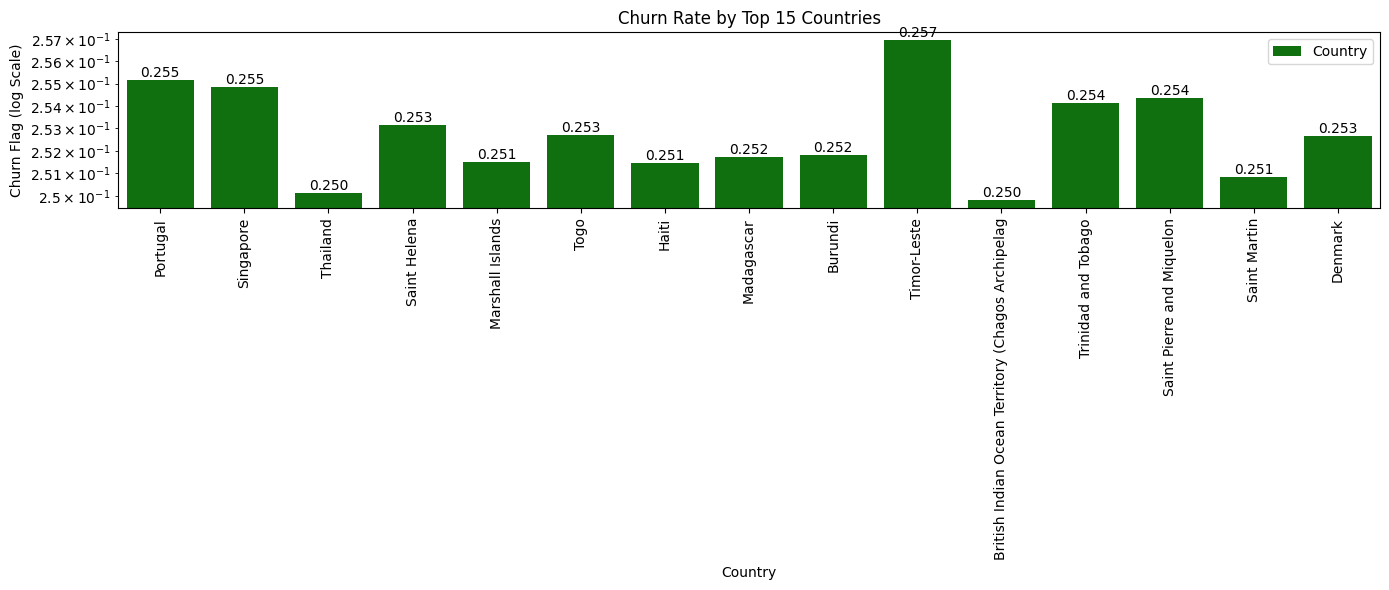

In [38]:
# Filter to get the top 15 countries by churn_flag mean (or total count, adjust as needed)
top_15_countries = churn_demo.groupby(
    'country')['churn_flag'].mean().nlargest(15).index
churn_demo_top15 = churn_demo[churn_demo['country'].isin(top_15_countries)]

# Create the figure
plt.figure(figsize=(14, 6))

# Create bar plot for the top 15 countries
sns.barplot(x="country", y="churn_flag", data=churn_demo_top15,
            color='green', label='Country', ci=None)

# Add value labels on top of each bar
for p in plt.gca().patches:
    height = p.get_height()
    plt.gca().text(p.get_x() + p.get_width() / 2., height,
                   f'{height:.3f}',
                   ha="center", va="bottom")

# Customize the plot with logarithmic scale
plt.yscale('log')  # Using symmetric log scale to handle values near zero
plt.xticks(rotation=90)
plt.title("Churn Rate by Top 15 Countries")
plt.xlabel("Country")
plt.ylabel("Churn Flag (log Scale)")
plt.legend()

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show plot
plt.show()

## 3.3 Engagement Metrics (Daily Activity)

The daily_activity table captures user engagement such as lessons completed, XP gained, and streak maintenance. Aggregating these variables allows comparison between churned vs. retained users.

In [ ]:
with engine.connect() as conn:
    activity = pd.read_sql("SELECT TOP 100000 * FROM daily_activity", conn)

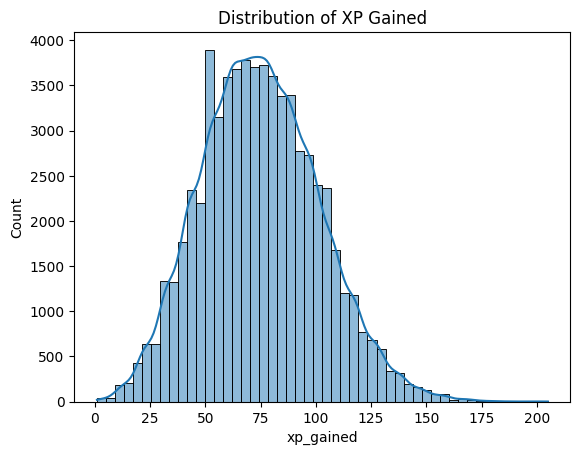

In [ ]:
# Limit to only positive, non-zero XP gained values for better visualization
sns.histplot(activity[activity["xp_gained"]>0]["xp_gained"], bins=50, kde=True)
plt.title("Distribution of XP Gained");

Text(0.5, 1.0, 'Lessons Completed by Churn Status')

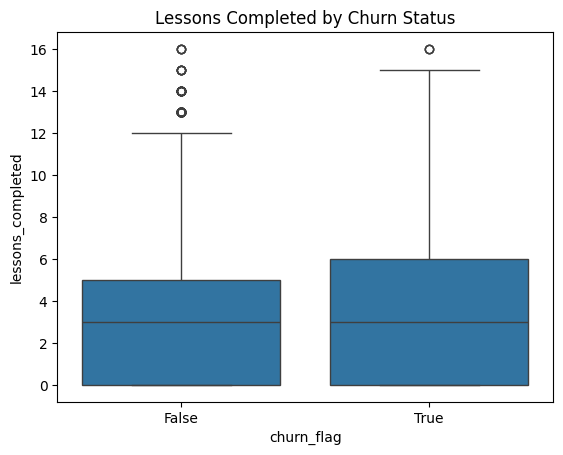

In [21]:
sns.boxplot(x="churn_flag", y="lessons_completed",
            data=activity.merge(churn, on="user_id"))
plt.title("Lessons Completed by Churn Status")

## 3.4 Notifications

Notifications are expected to influence engagement. We start with descriptive statistics of notifications per user, then calculate open/click-through rates across different channels (email, push, in-app).

In [23]:
with engine.connect() as conn:
    notifs = pd.read_sql("SELECT TOP 500000 * FROM notifications", conn)

Text(0.5, 1.0, 'Distribution of Notifications per User')

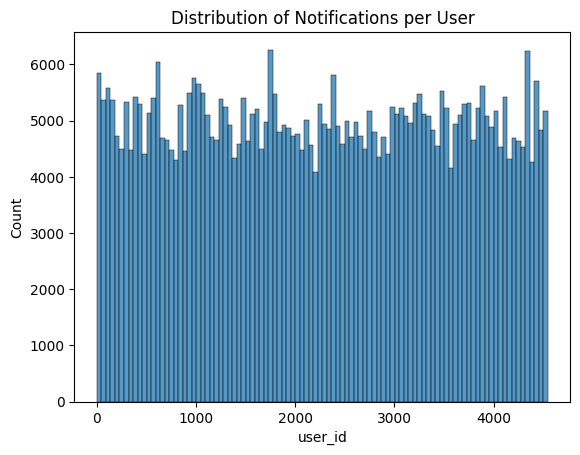

In [30]:
user_notifs = notifs.groupby('user_id').size().sort_values(ascending=False).reset_index(name='notif_count')
sns.histplot(notifs["user_id"], bins=100)
plt.title("Distribution of Notifications per User")


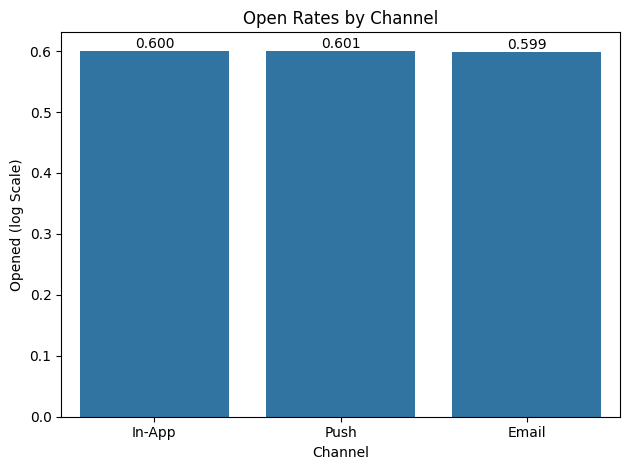

In [64]:
# Create the bar plot
sns.barplot(x="channel", y="opened", data=notifs, ci=None)

# Add value labels on top of each bar
for p in plt.gca().patches:
    height = p.get_height()
    plt.gca().text(p.get_x() + p.get_width() / 2., height,
                   f'{height:.3f}',
                   ha="center", va="bottom")

# Customize the plot with logarithmic scale
plt.title("Open Rates by Channel")
plt.xlabel("Channel")
plt.ylabel("Opened (log Scale)")

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show plot
plt.show()

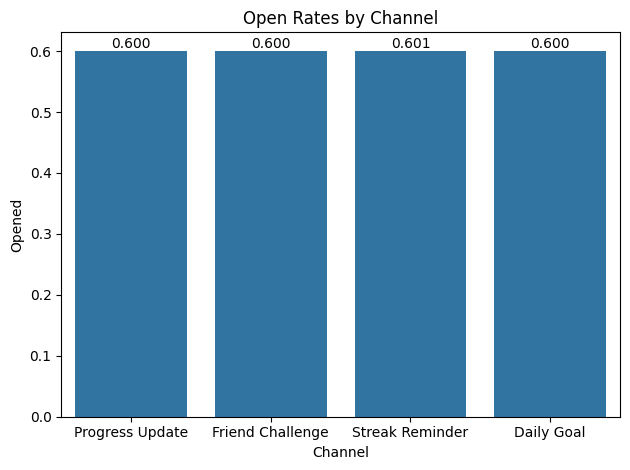

In [ ]:
# Create the bar plot
sns.barplot(x="notification_type", y="opened", data=notifs, ci=None)

# Add value labels on top of each bar
for p in plt.gca().patches:
    height = p.get_height()
    plt.gca().text(p.get_x() + p.get_width() / 2., height,
                   f'{height:.3f}',
                   ha="center", va="bottom")

# Customize the plot with logarithmic scale
plt.yscale('linear')
plt.title("Open Rates by Channel")
plt.xlabel("Channel")
plt.ylabel("Opened")
plt.xticks(rotation=90)

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show plot
plt.show()

## 3.5 Sessions

The sessionstable captures detailed engagement measures: session length, exercises completed, and accuracy rates. These variables help us distinguish between casual and highly committed learners.

In [48]:
with engine.connect() as conn:
    sessions = pd.read_sql("SELECT TOP 100000 * FROM sessions", conn)

Text(0.5, 1.0, 'Distribution of Session Length')

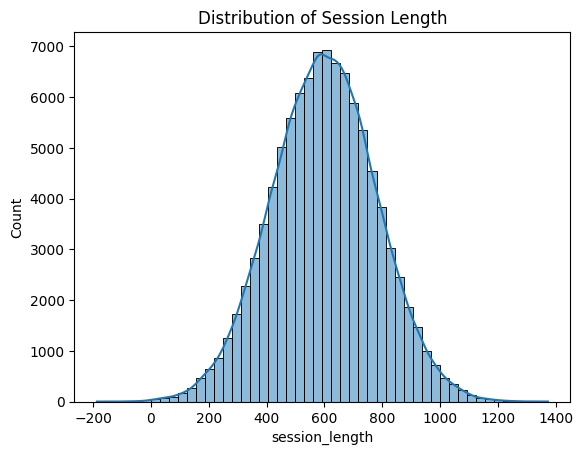

In [49]:

sns.histplot(sessions["session_length"], bins=50, kde=True)
plt.title("Distribution of Session Length")

Text(0.5, 1.0, 'Distribution of Accuracy')

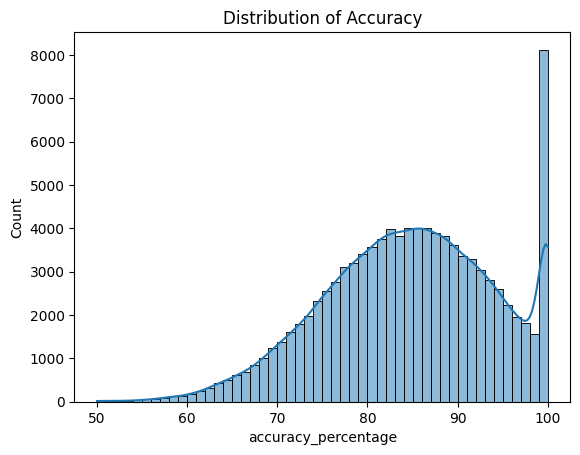

In [50]:
# Accuracy distribution 
sns.histplot(sessions["accuracy_percentage"], bins=50, kde=True) 
plt.title("Distribution of Accuracy")

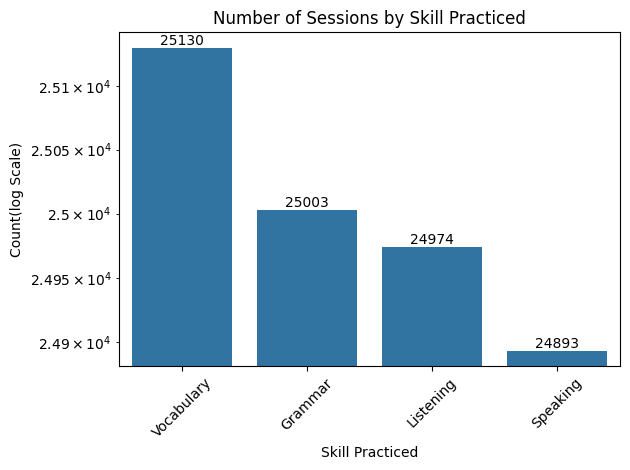

In [60]:

skill_counts = sessions['skill_practiced'].value_counts().reset_index()
skill_counts.columns = ['skill_practiced',
                        'count']  # Rename columns for clarity

# Create the bar plot
sns.barplot(x="skill_practiced", y="count", data=skill_counts, ci=None)

# Add value labels on top of each bar
for p in plt.gca().patches:
    height = p.get_height()
    plt.gca().text(p.get_x() + p.get_width() / 2., height,
                   f'{int(height)}',  # Use int to avoid decimal for counts
                   ha="center", va="bottom")

# Customize the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for readability if needed
plt.title("Number of Sessions by Skill Practiced")
plt.xlabel("Skill Practiced")
plt.ylabel("Count(log Scale)")
plt.yscale('log')

# Adjust layout to prevent label cutoff
plt.tight_layout()

# Show plot
plt.show()

## 3.6 Statistical Tests

In this section, we move beyond descriptive analysis to apply inferential statistical tests . While descriptive statistics summarize patterns in the data, inferential tests allow us to determine whether observed differences are statistically significant or could have arisen by chance. This is crucial in understanding which user attributes or platform interventions may drive churn, retention, and engagement.

We focus on three classes of tests:

### ANOVA (Analysis of Variance)
ANOVA helps us assess whether churn rates differ significantly across multiple categories of a variable, such as learning_motivation. For instance, we want to test if users motivated by "school," "work," or "personal interest" have statistically different churn rates.

Steps:

Group the dataset by learning_motivation.
Extract churn flags per group.
Run a one-way ANOVA using scipy.stats.f_oneway.
Interpret whether the mean churn rates differ significantly across motivations.

In [61]:
from scipy.stats import f_oneway

# Prepare groups 
groups = [group["churn_flag"] for _, group in churn_demo.groupby("learning_motivation")] 

# Run one-way ANOVA 
anova_result = f_oneway(*groups) 
print("ANOVA F-statistic:", anova_result.statistic) 
print("p-value:", anova_result.pvalue)

ANOVA F-statistic: 0.9250106807574007
p-value: 0.4276270054460144


### T-tests and Mann-Whitney U tests  
To evaluate retention differences between two groups , such as high vs. low notification exposure, we use tests for comparing two distributions.

If the data is approximately normal with equal variance, we use a t-test ( scipy.stats.ttest_ind).
If normality assumptions are violated, we use the Mann-Whitney U test ( scipy.stats.mannwhitneyu), which is non-parametric.

In [70]:
query = """
WITH NotificationCounts AS (
    SELECT user_id, COUNT(channel) AS notifications_sent
    FROM notifications
    GROUP BY user_id
)
SELECT 
    u.user_id,
    u.gender,
    u.country,
    u.learning_motivation,
    c.churn_flag,
    c.retention_days,
    COALESCE(nc.notifications_sent, 0) AS notifications_sent
FROM users u
JOIN churn_labels c ON u.user_id = c.user_id
LEFT JOIN NotificationCounts nc ON u.user_id = nc.user_id;
"""
with engine.connect() as conn:
    churn_demo_notif_test = pd.read_sql(query, conn)

In [71]:
from scipy.stats import ttest_ind, mannwhitneyu 

# Split groups based on notification volume threshold (e.g., median) 
median_notifications = churn_demo_notif_test["notifications_sent"].median()
high_notif = churn_demo_notif_test[churn_demo_notif_test["notifications_sent"]
                                   > median_notifications]["retention_days"]
low_notif = churn_demo_notif_test[churn_demo_notif_test["notifications_sent"]
                       <= median_notifications]["retention_days"]

# T-test 
t_stat, t_pval = ttest_ind(high_notif, low_notif, equal_var=False) 

# Mann-Whitney U (robust alternative) 
u_stat, u_pval = mannwhitneyu(high_notif, low_notif) 
print("T-test p-value:", t_pval) 
print("Mann-Whitney U p-value:", u_pval)

T-test p-value: 5.264866025546153e-40
Mann-Whitney U p-value: 1.0121098100633549e-41


### Chi-square Tests for Categorical Variables  
Chi-square tests assess whether churn is independent of categorical variables like gender or country. This is useful when both the predictor and outcome are categorical.

Steps:

Construct a contingency table of counts (eg, churned vs. retained across genders).
Run a chi-square test with scipy.stats.chi2_contingency.
Assess whether distributions differ significantly.

In [ ]:
from scipy.stats import chi2_contingency 

# Contingency table: churn by gender 
contingency = pd.crosstab(churn_demo["gender"], churn_demo["churn_flag"]) 
chi2, p, dof, expected = chi2_contingency(contingency) 
print("Chi-square statistic:", chi2) 
print("p-value:", p)

Chi-square statistic: 0.7258782700975344
p-value: 0.8671008933026728
